In [1]:
#1) Get datasets #TODO infopinion on allocine
#2) Train models #ok
#3) Test models #ok
#4) LRP frozen et fine-tuned # ok
#5) Visu CDB # ok
#5bis) PCA # ok
#6) Cross-task fine-tuning # TODO

In [2]:
import numpy as np
import random as rd
import os
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup

def seed_worker(worker_id):
    worker_seed = seed
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)
    
def set_seed(seed):
    """Set all seeds to make results reproducible (deterministic mode).
       When seed is None, disables deterministic mode.
    :param seed: an integer to your choosing
    """
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        rd.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
seed = 42
set_seed(seed)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
model = AutoModelForSequenceClassification.from_pretrained('camembert-base')
model.to(device)

tokenizer = AutoTokenizer.from_pretrained('camembert-base', do_lowercase=True)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

In [4]:
import datasets
from Code.data_processing import get_text_tokens, create_dataset
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader 
from Code.data_processing import preprocess, tokenize
import pandas as pd
    
def build_set(dataset, tokenizer, batch_size=4):
    if dataset == 'allocine': 
        dataset = datasets.load_dataset("allocine")
        dataset = dataset.map(lambda a: {'review':preprocess(a['review'], full=True), 'label': a['label']}, batched=False)
        tokenized_dataset_full = dataset.map(lambda a: tokenize(a["review"], tokenizer, shorten=False), batched=True)
        tokenized_dataset_full = tokenized_dataset_full.rename_column("review", "text")
        tokenized_dataset_full['val'] = tokenized_dataset_full['validation']
        
    elif dataset == 'infopinion':
        #dataDfInit = pd.read_csv("../NeededFiles/dataset/rtbf_dataset_14000_pp_post2012_2jan.csv", sep='|')
        dataDfInit = pd.read_csv("../NeededFiles/dataset/rtbf_dataset_10000_pp_11may23.csv", sep='|')
        #dataDfInit = dataDfInit.rename(columns={"mainparagraph": "text"})
        dataDfInit = dataDfInit.rename(columns={"text_clean": "text"})
        dataDfInit['label'] = dataDfInit.apply(lambda a: int(a['label'] == 'chron'), axis=1)
        dataDfInit["text"] = dataDfInit["text"].apply(lambda a : preprocess(a, full=True))
        train_df, val_df, test_df = create_dataset(dataDfInit)
        
        train_df = train_df[['text', 'label']]
        val_df = val_df[['text', 'label']]
        test_df = test_df[['text', 'label']]

        train_ds = datasets.Dataset.from_pandas(train_df.sample(frac=1, random_state = 42))
        val_ds = datasets.Dataset.from_pandas(val_df.sample(frac=1, random_state = 42))
        test_ds = datasets.Dataset.from_pandas(test_df.sample(frac=1, random_state = 42))

        dataset = datasets.DatasetDict({"train":train_ds,"val":val_ds, "test": test_ds})
        tokenized_dataset_full = dataset.map(lambda a: tokenize(a["text"], tokenizer, shorten=True), batched=True)
    
    else: 
        print('Please precise allocine of infopinion dataset')
    
    train_text, Y_train = tokenized_dataset_full["train"]["text"], tokenized_dataset_full["train"]["label"]
    val_text, Y_val = tokenized_dataset_full["val"]["text"], tokenized_dataset_full["val"]["label"]
    test_text, Y_test = tokenized_dataset_full["test"]["text"], tokenized_dataset_full["test"]["label"]

    train_st = tokenized_dataset_full["train"]['special_tokens']
    val_st = tokenized_dataset_full["val"]['special_tokens']
    test_st = tokenized_dataset_full["test"]['special_tokens']

    tokenized_dataset = tokenized_dataset_full.remove_columns(['text', 'special_tokens'])
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, max_length = 512, padding = 'max_length')

    g_train = torch.Generator()
    g_train.manual_seed(seed)

    g_val = torch.Generator()
    g_val.manual_seed(seed)

    g_test = torch.Generator()
    g_test.manual_seed(seed)
    
    train = DataLoader(tokenized_dataset["train"], 
                       shuffle=False,
                       batch_size=batch_size,
                       collate_fn=data_collator,
                       generator=g_train)

    val = DataLoader(tokenized_dataset["val"], 
                       shuffle=False,
                       batch_size=batch_size,
                       collate_fn=data_collator,
                       generator=g_val)

    test = DataLoader(tokenized_dataset["test"], 
                       shuffle=False,
                       batch_size=batch_size,
                       collate_fn=data_collator,
                       generator=g_val)
        
    return (train, val, test), (train_text, val_text, test_text), (train_st, val_st, test_st)

batch_size=4
dataset = 'allocine'
sets, texts, special_tokens = build_set(dataset, tokenizer, batch_size=batch_size)
train, val, test = sets[0], sets[1], sets[2]
train_text, val_text, test_text = texts[0], texts[1], texts[2]
train_st, val_st, test_st = special_tokens[0], special_tokens[1], special_tokens[2]

dataset2 = 'infopinion' if dataset == 'allocine' else 'allocine'
sets2, texts2, special_tokens2 = build_set(dataset2, tokenizer, batch_size=batch_size)
train2, val2, test2 = sets2[0], sets2[1], sets2[2]
train_text2, val_text2, test_text2 = texts2[0], texts2[1], texts2[2]
train_st2, val_st2, test_st2 = special_tokens2[0], special_tokens2[1], special_tokens2[2]

Found cached dataset allocine (/DATA3/users/jebogaert/.cache/huggingface/datasets/allocine/allocine/1.0.0/ea86b1dc05eae3a45a07b6281f2d4033b5fe7927b1008d06aa457ca1eae660d0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /DATA3/users/jebogaert/.cache/huggingface/datasets/allocine/allocine/1.0.0/ea86b1dc05eae3a45a07b6281f2d4033b5fe7927b1008d06aa457ca1eae660d0/cache-4eb667471f7db94f.arrow
Loading cached processed dataset at /DATA3/users/jebogaert/.cache/huggingface/datasets/allocine/allocine/1.0.0/ea86b1dc05eae3a45a07b6281f2d4033b5fe7927b1008d06aa457ca1eae660d0/cache-1fc32a7d3e3dd2d9.arrow
Loading cached processed dataset at /DATA3/users/jebogaert/.cache/huggingface/datasets/allocine/allocine/1.0.0/ea86b1dc05eae3a45a07b6281f2d4033b5fe7927b1008d06aa457ca1eae660d0/cache-594160fe38f1e19d.arrow
Loading cached processed dataset at /DATA3/users/jebogaert/.cache/huggingface/datasets/allocine/allocine/1.0.0/ea86b1dc05eae3a45a07b6281f2d4033b5fe7927b1008d06aa457ca1eae660d0/cache-c74c73d06a1e3707.arrow
Loading cached processed dataset at /DATA3/users/jebogaert/.cache/huggingface/datasets/allocine/allocine/1.0.0/ea86b1dc05eae3a45a07b6281f2d4033b5fe7927b1008d06aa457ca1eae660d0/cach

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [5]:
import time 
import copy as cp
from torch.nn import Softmax
from tqdm.notebook import tqdm
import datetime


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


def train_model(model, train_set, val, device, epochs=2, inplace=False):
    
    if not inplace:
        model = cp.deepcopy(model)
    
    optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8
                )

    batches_per_epoch = len(train_set) // batch_size

    total_steps = int(batches_per_epoch * epochs)

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

    
    training_stats = []

    total_t0 = time.time()
    model.train()
    
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()

        total_train_loss = 0
        all_input_ids = []
        for step, batch in enumerate(tqdm(train_set, total=len(train_set))):

            model.zero_grad()
            optimizer.zero_grad()
            
            cp_batch = cp.deepcopy(batch)
            b_input_ids = cp_batch['input_ids'].to(device)
            all_input_ids.append(b_input_ids.detach().cpu())
            b_input_mask = cp_batch['attention_mask'].to(device)
            b_labels = cp_batch['labels'].to(device)        

            loss, logits = model(b_input_ids, 
                                 token_type_ids=None, 
                                 attention_mask=b_input_mask, 
                                 labels=b_labels)[:2]

            total_train_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            scheduler.step()

        avg_train_loss = total_train_loss / len(train_set)            

        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================

        print("")
        print("Running Validation...")

        t0 = time.time()

        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        for step, batch in enumerate(tqdm(val, total=len(val))):

            cp_batch = cp.deepcopy(batch)
            b_input_ids = cp_batch['input_ids'].to(device)
            b_input_mask = cp_batch['attention_mask'].to(device)
            b_labels = cp_batch['labels'].to(device)

            with torch.no_grad():        

                loss, logits = model(b_input_ids, 
                                        token_type_ids=None, 
                                        attention_mask=b_input_mask,
                                        labels=b_labels)[:2]

            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)


        avg_val_accuracy = total_eval_accuracy / len(val)
        print("  Accuracy: {0:.4f}".format(avg_val_accuracy))

        avg_val_loss = total_eval_loss / len(val)

        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.4f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    
    return model, all_input_ids

def test_model(model, test, device, get_preds = False):
    print("")
    print("Running Test...")
    t0 = time.time()
    total_eval_accuracy = 0

    model.eval()

    predictions, true_labels = [], []

    for step, batch in enumerate(tqdm(test, total = len(test))):

        cp_batch = cp.deepcopy(batch)
        b_input_ids = cp_batch['input_ids'].to(device)
        b_input_mask = cp_batch['attention_mask'].to(device)
        b_labels = cp_batch['labels'].to(device)

        with torch.no_grad():        
            outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)

        logits = outputs[0]
        if get_preds:
            soft = Softmax()
            preds = soft(logits).detach().cpu().numpy()
            predictions += list(np.argmax(preds, axis=1))
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        true_labels.append(label_ids)


    avg_test_accuracy = total_eval_accuracy / len(test)
    print("  Accuracy: {0:.4f}".format(avg_test_accuracy))
    
    if get_preds:
        return predictions

In [6]:
import os 
def save_model(model, tokenizer, output_dir):
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Saving model to %s" % output_dir)

    
    model_to_save = model.module if hasattr(model, 'module') else model
    model_to_save.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

In [7]:
TRAIN = False
if TRAIN:
    ft_model, _ = train_model(model, train, val, device, epochs=2)
    test_model(ft_model, test, device)
    #save_model(ft_model, tokenizer, f'Finetuned_model_{dataset}')
    
else: #Loads the model from memory to avoid recomputing it 
    ft_model = AutoModelForSequenceClassification.from_pretrained(f'Finetuned_model_{dataset}')
    ft_model.to(device)
    tokenizer = AutoTokenizer.from_pretrained(f'Finetuned_model_{dataset}')

In [9]:
test_model(ft_model, train, device)
test_model(ft_model, test, device)


Running Test...


  0%|          | 0/40000 [00:00<?, ?it/s]

  Accuracy: 0.9749

Running Test...


  0%|          | 0/5000 [00:00<?, ?it/s]

  Accuracy: 0.9707


In [10]:
from Code.model_explainer import extract_embeddings
frozen_train_emb, labels_train, _ = extract_embeddings(train, model, layers = [12])
frozen_val_emb, labels_val, _ = extract_embeddings(val, model, layers = [12])
frozen_test_emb, labels_test, _ = extract_embeddings(test, model, layers = [12])

ft_train_emb, _, preds_train_ft = extract_embeddings(train, ft_model, layers = [12])
ft_test_emb, _, preds_test_ft = extract_embeddings(test,ft_model, layers = [12])

 13%|████████████████████▌                                                                                                                                            | 5101/40000 [03:00<20:35, 28.25it/s]


KeyboardInterrupt: 

In [11]:
#LRP on allocine :D

from BERT_explainability.modules.layers_ours import Linear
from torch.nn.parameter import Parameter
from sklearn.metrics import accuracy_score

from torch import nn
from BERT_explainability.modules.layers_ours import Dropout, Linear, Tanh

class RobertaClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config):
        super().__init__()
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout1 = Dropout(classifier_dropout)
        self.dense = Linear(config.hidden_size, config.hidden_size)
        self.tanh = Tanh()
        self.dropout2 = Dropout(classifier_dropout)
        self.out_proj = Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        try:
            x = features[:, 0, :] # take <s> token (equiv. to [CLS])
        except:
            x = features 
        x = self.dropout1(x)
        x = self.dense(x)
        x = self.tanh(x)
        x = self.dropout2(x)
        x = self.out_proj(x)
        return x

    def relprop(self, cam, **kwargs):
        cam = self.out_proj.relprop(cam, **kwargs)
        cam = self.dropout2.relprop(cam, **kwargs)
        cam = self.tanh.relprop(cam, **kwargs)
        cam = self.dense.relprop(cam, **kwargs)
        cam = self.dropout1.relprop(cam, **kwargs)
        return cam

def flat_accuracy(logits, labels):
    return np.mean([int(np.argmax(logit) == label) for logit, label in zip(logits, labels)])

In [12]:
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import get_linear_schedule_with_warmup
import random
import numpy as np 
import time
import copy as cp
from torch.nn import CrossEntropyLoss
from tqdm.notebook import tqdm


def train_frozen_model(model, train, val, labels_train, labels_val):
    
    rFrozen = cp.deepcopy(model)
    seed = 42
    total_train_loss = 0
    batch_size = 32 if dataset == "allocine" else 4
    epochs = 20
    optimizer = torch.optim.AdamW(rFrozen.parameters(),
                      lr = 1e-4 if dataset == "allocine" else 1e-3, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                      eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

    batches_per_epoch = len(labels_train) // batch_size

    total_steps = int(batches_per_epoch * epochs)

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)

    training_stats = []

    total_t0 = time.time()
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()

        total_train_loss = 0

        rFrozen.train()

        input_ids, labels = [], []
        for step, batch in enumerate(tqdm(zip(train, labels_train), total=len(labels_train))):
            cp_batch = cp.deepcopy(batch)

            input_ids += [cp_batch[0]]
            labels += [cp_batch[1]]

            if step%batch_size != batch_size-1 and step!=len(labels_train)-1:
                continue

            b_input_ids = torch.tensor(input_ids).to(device)
            b_labels = torch.tensor(labels).to(device)
            input_ids, labels = [], []

            rFrozen.zero_grad()        

            logits = rFrozen(b_input_ids,  
                            labels=b_labels)

            loss= CrossEntropyLoss().forward(logits.view(-1, 2), b_labels.view(-1))

            total_train_loss += loss.item()*batch_size

            loss.backward()

            torch.nn.utils.clip_grad_norm_(rFrozen.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(labels_train)            

        print("")
        print("  Average training loss: {0:.4f}".format(avg_train_loss))

        # ========================================
        #               Validation
        # ========================================

        print("")
        print("Running Validation...")

        t0 = time.time()

        rFrozen.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        labels, input_ids = [], []

        for step, batch in enumerate(tqdm(zip(val, labels_val), total=len(labels_val))):

            cp_batch = cp.deepcopy(batch)

            input_ids += [cp_batch[0]]
            labels += [cp_batch[1]]

            if step%batch_size != batch_size-1 and step!=len(labels_val)-1:
                continue

            b_input_ids = torch.tensor(input_ids).to(device)
            b_labels = torch.tensor(labels).to(device)
            input_ids, labels = [], []

            with torch.no_grad():        

                logits = rFrozen(b_input_ids,  
                            labels=b_labels)

            loss= CrossEntropyLoss().forward(logits.view(-1, 2), b_labels.view(-1))
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids)


        avg_val_accuracy = total_eval_accuracy / (len(labels_val)/batch_size)
        print("  Accuracy: {0:.4f}".format(avg_val_accuracy))

        avg_val_loss = total_eval_loss / (len(labels_val)/batch_size)

        print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    return rFrozen

def test_frozen_model(rFrozen, test, labels_test, get_preds = False):
    
    rFrozen.eval()
    
    total_eval_accuracy = 0
    total_eval_loss = 0
    batch_size = 1
    
    predictions = []
    
    labels, input_ids = [], []
    for step, batch in enumerate(tqdm(zip(test, labels_test), total=len(labels_test))):

        cp_batch = cp.deepcopy(batch)

        input_ids += [cp_batch[0]]
        labels += [cp_batch[1]]

        if step%batch_size != batch_size-1 and step!=len(labels_test)-1:
            continue
            
        b_input_ids = torch.tensor(input_ids).to(device)
        b_labels = torch.tensor(labels).to(device)
        input_ids, labels = [], []

        with torch.no_grad():        

            logits = rFrozen(b_input_ids,  
                            labels=b_labels)
    
        loss= CrossEntropyLoss().forward(logits.view(-1, 2), b_labels.view(-1))

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        predictions += [i for i in np.argmax(logits, axis=1)] 

    avg_test_accuracy = total_eval_accuracy /(len(labels_test)/batch_size)
    print("  Accuracy: {0:.4f}".format(avg_test_accuracy))

    avg_test_loss = total_eval_loss /(len(labels_test)/batch_size)

    print("  Test Loss: {0:.4f}".format(avg_test_loss))
    
    if get_preds:
        return predictions

In [13]:
configFro = model.config
configFro.classifier_dropout=0 #delete the dropout for the frozen model as it reaches better results without
rFrozen = RobertaClassificationHead(model.config)
rFrozen.to(device)

if TRAIN: 
    
    trained_model_frozen = train_frozen_model(rFrozen, frozen_train_emb[12], frozen_val_emb[12], labels_train, labels_val)
    test_frozen_model(trained_model_frozen, frozen_test_emb[12], labels_test)
    
    frozen_model = cp.deepcopy(model)
    frozen_model.classifier = trained_model_frozen
    frozen_model.to(device)
    frozen_model.eval()
    
    save_model(frozen_model, tokenizer, f'Frozen_model_{dataset}')
else:
    frozen_model = AutoModelForSequenceClassification.from_pretrained(f'Frozen_model_{dataset}')
    frozen_model.to(device)
    tokenizer = AutoTokenizer.from_pretrained(f'Frozen_model_{dataset}')

In [14]:
preds_test_frozen = test_model(frozen_model, test, device, get_preds = True)
preds_train_frozen = test_model(frozen_model, train, device, get_preds = True)


Running Test...


  0%|          | 0/5000 [00:00<?, ?it/s]

/tmp/ipykernel_659352/3065397803.py:185: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = soft(logits).detach().cpu().numpy()


  Accuracy: 0.9431

Running Test...


  0%|          | 0/40000 [00:00<?, ?it/s]

  Accuracy: 0.9377


In [15]:
#Explainability part

from BERT_explainability.modules.layers_ours import Linear
from torch.nn.parameter import Parameter
from sklearn.metrics import accuracy_score
from Code.model_explainer import save_model

from BERT_explainability.modules.BERT.BertForSequenceClassification import CamembertForSequenceClassification
from BERT_explainability.modules.BERT.ExplanationGenerator import Generator

model_expl_frozen = CamembertForSequenceClassification.from_pretrained(f'Frozen_model_{dataset}')
model_expl_ft = CamembertForSequenceClassification.from_pretrained(f'Finetuned_model_{dataset}')
model_expl_frozen.eval()
model_expl_ft.eval()

explaner_frozen = Generator(model_expl_frozen)
explaner_ft = Generator(model_expl_ft)

tokenizer_expl_frozen = AutoTokenizer.from_pretrained(f'Frozen_model_{dataset}')
tokenizer_expl_ft = AutoTokenizer.from_pretrained(f'Finetuned_model_{dataset}')

model_expl_frozen.to(device)
model_expl_ft.to(device)

You are using a model of type camembert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
You are using a model of type camembert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (add1): Add()
      (add2): Add()
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (matmul1): MatMul()
              (matmul2): MatMul()
              (softmax): Softmax(dim=-1)
 

In [23]:
def normalize(vector, fullExpl=True):
    neg = sum(vector) < 0
    if neg:
        vector = [-i for i in vector]
    
    min_val = min(vector)
    max_val = max(vector)
    if min_val == max_val:
        assert len(vector) == 1
        vector = [1]
    else:
        if max_val == min_val:
            print(vector)
        vector = [(i-min_val)/(max_val-min_val) for i in vector]
        assert max(vector) == 1
        assert min(vector) == 0
    vect_sum = sum(vector)
    vect_len = len(vector)
    
    normalized = [i for i in vector]
    if fullExpl:
        normalized = [i/vect_sum for i in normalized]
    if neg:
        normalized = [-i for i in normalized]
    
    return normalized

In [17]:
from Code.model_explainer import normalize
from Code.data_processing import convert_to_tok, retokenize
import json

DO_LRP = True
 
if DO_LRP:
    with open(f'../NeededFiles/ExplanationsFrozenFinetuned_{dataset}.jsonl', 'w') as f:
        pass #Delete file content if existing 
    text_batch = test_text
    expls = [{'Text':[], 'Preds': [], 'LRP_Frozen':[], 'LRP_Finetuned':[]} for i in text_batch]
    dict_explanations = {}
    classifications = ["information", "opinion"]
    
    for nbr, itm in enumerate(tqdm(text_batch, total = len(text_batch))):  
        
        #Frozen
        shorten = False if dataset == "allocine" else True
        itm = get_text_tokens(itm, tokenizer_expl_frozen, shorten=shorten)
        
        encoding = tokenize([itm], tokenizer_expl_frozen)
        special_tokens = encoding['special_tokens']
        input_ids = torch.tensor(encoding['input_ids']).to(device) 
        attention_mask = torch.tensor(encoding['attention_mask']).to(device)

        expl = explaner_frozen.generate_LRP(input_ids=input_ids, attention_mask=attention_mask, start_layer=1)[0]
        expl = (expl - expl.min()) / (expl.max() - expl.min())
        output = torch.nn.functional.softmax(model_expl_frozen(input_ids=input_ids, attention_mask=attention_mask)[1], dim=-1).to("cpu")

        classification = output.argmax(dim=-1).item()
        class_name = classifications[classification]
        if class_name == "opinion":
            expl *= (-1)

        tokens = convert_to_tok(input_ids.flatten(), tokenizer_expl_frozen, special_tokens[0])
        tokensFinal, expli = retokenize(tokens, expl)
            
        expli = [i.item() for i in normalize(expli)]
        expls[nbr]['LRP_Frozen'] = [(tok, expl) for tok,expl in zip(tokensFinal, expli)]
        expls[nbr]['Text'] = tokensFinal
        expls[nbr]['Preds'] += [classification]
        
        #FineTuned
        expl = explaner_ft.generate_LRP(input_ids=input_ids, attention_mask=attention_mask, start_layer=1)[0]
        expl = (expl - expl.min()) / (expl.max() - expl.min())
        output = torch.nn.functional.softmax(model_expl_ft(input_ids=input_ids, attention_mask=attention_mask)[1], dim=-1).to("cpu")

        classification = output.argmax(dim=-1).item()
        class_name = classifications[classification]
        if class_name == "opinion":
            expl *= (-1)

            
        tokensFinal, expli = retokenize(tokens, expl)
            
        expli = [i.item() for i in normalize(expli)]
        expls[nbr]['LRP_Finetuned'] = [(tok, expl) for tok,expl in zip(tokensFinal, expli)]
        expls[nbr]['Preds'] += [classification]
        
        
        with open(f'../NeededFiles/ExplanationsFrozenFinetuned_{dataset}.jsonl', 'a+') as f:
            elem = expls[nbr]
            elem['Preds'] = [round(i) for i in elem['Preds']]
            json.dump(elem, f)
            f.write('\n')

  0%|          | 0/20000 [00:00<?, ?it/s]

In [21]:
import json
expls = []
with open(f'../NeededFiles/ExplanationsFrozenFinetuned_{dataset}.jsonl', 'r') as f:
    for nbr, line in enumerate(f):
        expls += [json.loads(line)]
        assert len(expls[nbr]['LRP_Finetuned']) == len(expls[nbr]['LRP_Frozen']) == len(expls[nbr]['Text'])
if dataset == "allocine":
    assert len(expls)==20000
else:
    assert len(expls)==10000

In [24]:
full_fro, full_ft, full_tkns = [], [], []

full_fro_pos, full_ft_pos, full_tkns_pos = [], [], []
full_fro_neg, full_ft_neg, full_tkns_neg = [], [], []

for pos, expl in enumerate(expls):
    preds = expl['Preds']
    fro_pred, ft_pred = round(preds[0]), round(preds[1])
    
    if not (ft_pred == fro_pred):
        pass
        
    fro_words = [i[0].lower() for i in expl['LRP_Frozen']]
    ft_words = [i[0].lower() for i in expl['LRP_Finetuned']]
    tkns = [i.lower() for i in expl['Text']]
    
    
    fro_expl = [i[1] for i in expl['LRP_Frozen']]
    ft_expl = [i[1] for i in expl['LRP_Finetuned']]
    
    
    tkns = expl['Text']    
        
    if ft_pred == 1:
        ft_expl = [i if i<0 else 0 for i in ft_expl]
        ft_expl = normalize(ft_expl)  
        full_ft_neg += ft_expl
    else:
        ft_expl = [i if i>=0 else 0 for i in ft_expl]
        ft_expl = normalize(ft_expl)
        full_ft_pos += ft_expl
        
    
    if fro_pred == 1:
        fro_expl = [i if i<0 else 0 for i in fro_expl]
        fro_expl = normalize(fro_expl)
        full_fro_neg += fro_expl
    else:
        fro_expl = [i if i>=0 else 0 for i in fro_expl]
        fro_expl = normalize(fro_expl)
        full_fro_pos += fro_expl
        
    assert len(fro_expl) == len(ft_expl) == len(tkns)

    full_fro += fro_expl
    full_ft += ft_expl
    full_tkns += tkns

In [25]:
avg_fro_relevance = {}
for tok, expli in tqdm(zip(full_tkns, full_fro), total = len(full_tkns)):
    tok = tok.lower().replace('</s>', '')
    avg_fro_relevance[tok] = avg_fro_relevance.get(tok, []) + [expli]


avg_ft_relevance = {}
for tok, expli in tqdm(zip(full_tkns, full_ft), total = len(full_tkns)):
    tok = tok.lower().replace('</s>', '')
    avg_ft_relevance[tok] = avg_ft_relevance.get(tok, []) + [expli]

  0%|          | 0/2207309 [00:00<?, ?it/s]

  0%|          | 0/2207309 [00:00<?, ?it/s]

In [26]:
words_fro_relevance = [(i[0], abs(sum(i[1])/len(i[1]))) for i in list(avg_fro_relevance.items()) if len(i[1])>=100]
best_fro = sorted(words_fro_relevance, key=lambda a: a[1], reverse=True) 

print(best_fro[:10])
print(best_fro[-10:])

words_ft_relevance = [(i[0], sum(i[1])/len(i[1])) for i in list(avg_ft_relevance.items()) if len(i[1])>=100]
best_ft = sorted(words_ft_relevance, key=lambda a: a[1], reverse=True) 

print(best_ft[:10])
print(best_ft[-10:])

[('daube', 0.04310632708935408), ('ennuyeux', 0.04201026499020664), ('nullité', 0.040162429985483604), ('navet', 0.030500968274053995), ('creux', 0.029987852318053836), ('chiant', 0.0286101950062862), ('grotesque', 0.02850222775472625), ('inutile', 0.027135147063766313), ('nul', 0.02705300922367741), ('médiocrité', 0.026083137358473528)]
[('attend', 2.2153956467748695e-05), ('sortir', 2.1258104534680203e-05), ('rend', 2.103530013363687e-05), ('savoir', 2.0001113619129185e-05), ('choses', 1.666812836273635e-05), ('va', 1.2872886252485353e-05), ('lors', 9.162047865156701e-06), ('prend', 4.246721385723e-06), ('certaine', 6.972627571636193e-07), ('qui', 2.667303582294371e-07)]
[('ennuyeux', 0.06368357368822929), ('daube', 0.0564294113084566), ('nullité', 0.05330487499182612), ('navet', 0.05024641677357869), ('éviter', 0.04838957965248203), ('nul', 0.04792575474982253), ('plat', 0.046946949884012185), ('fade', 0.04429207029478891), ('chiant', 0.040885044100638826), ('ridicule', 0.0406386193

In [28]:
differences = [0 for i in words_fro_relevance]
for count, ((tok_fro, val_fro), (tok_ft, val_ft)) in enumerate(zip(words_fro_relevance, words_ft_relevance)):
    assert tok_fro == tok_ft
    differences[count] = (abs(val_ft) - abs(val_fro), tok_fro)

print(sorted(differences)[-20:])
print(sorted(differences)[:20])

[(0.020737306292964167, 'nanar'), (0.02073942718077257, 'clichés'), (0.020872745526145122, 'nul'), (0.02088970881151698, 'superbe'), (0.02155336478286629, 'magique'), (0.02167330869802265, 'ennuyeux'), (0.02168169946968769, 'recommande'), (0.021941952787280474, 'inoubliable'), (0.022860485217723513, 'magnifiquement'), (0.02330294583420933, 'excellent'), (0.023974253659848198, 'éviter'), (0.024829242434944086, 'poignant'), (0.02493073558302511, 'merveille'), (0.02528061608160811, 'magnifique'), (0.02547671169814471, 'bijou'), (0.025720750915046442, 'plat'), (0.028116944028671584, 'émouvant'), (0.028709514314246065, 'adoré'), (0.030578168240020805, 'régal'), (0.03900963780899951, 'bouleversant')]
[(-0.008382567614174732, 'regardez'), (-0.007428761830172941, 'vieilli'), (-0.006459927688697376, 'revu'), (-0.0062014531733259924, 'penser'), (-0.00584102852044195, 'besson'), (-0.005684461683921911, 'sauce'), (-0.0055234190863452486, 'proche'), (-0.0052499074127584045, 'mourir'), (-0.005180941

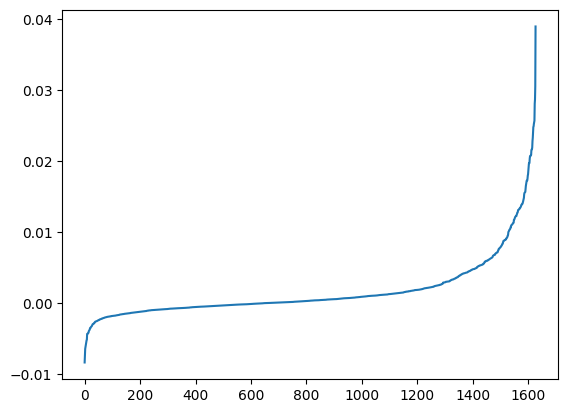

In [30]:
import matplotlib.pyplot as plt

plt.plot([i[0] for i in sorted(differences)])
plt.show()

In [ ]:
!git clone https://github.com/cdebodt/Fast_Multi-scale_NE.git
!mv Fast_Multi-scale_NE MultiScaleTsne

In [15]:
import numpy as np
from matplotlib.colors import ListedColormap
from  MultiScaleTsne.mstSNE import eucl_dist_matr, mstsne
import matplotlib.pyplot as plt

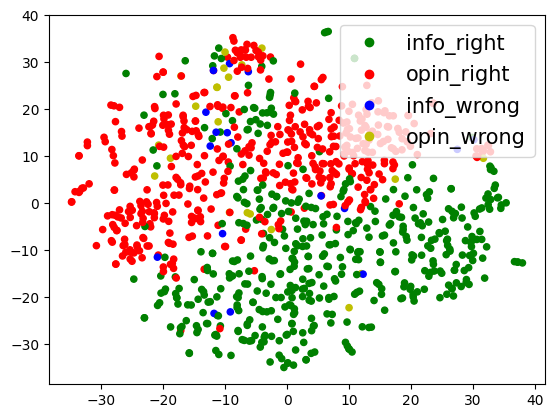

In [16]:
text_emb = np.array(frozen_test_emb[12]) 
dm_hd = eucl_dist_matr(text_emb)
X_embedded = mstsne(X_hds=text_emb, init='pca', n_components=2, dm_hds=dm_hd, seed_mstsne=seed)

colors = [0 for _ in X_embedded]
for pos, i in enumerate(X_embedded):
    if labels_test[pos] == 0 and preds_test_frozen[pos] == 0:
        colors[pos] = 0
    elif labels_test[pos] == 1 and preds_test_frozen[pos] == 1:
        colors[pos] = 1
    elif labels_test[pos] == 0 and preds_test_frozen[pos] == 1:
        colors[pos] = 2
    elif labels_test[pos] == 1 and preds_test_frozen[pos] == 0:
        colors[pos] = 3
colorMap = ListedColormap(['g','r','b', 'y'])
if dataset == 'infopinion':
    classes = ['info_right', 'opin_right', 'info_wrong', 'opin_wrong']
else: 
    classes = ['pos_right', 'neg_right', 'pos_wrong', 'neg_wrong']
    
scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=colors, cmap=colorMap, s=20)
plt.legend(handles=scatter.legend_elements()[0], labels=classes, loc = 'upper right', fontsize="15")
plt.show()

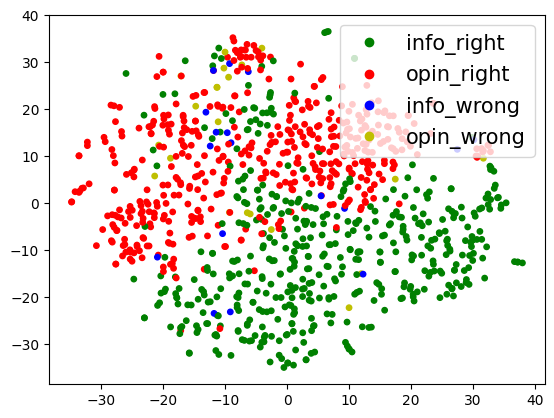

In [18]:
#X_emb_fro = X_embedded
#colors_fro = colors
#classes_fro = classes
scatter = plt.scatter(X_emb_fro[:,0], X_emb_fro[:,1], c=colors_fro, cmap=colorMap, s=15)
plt.legend(handles=scatter.legend_elements()[0], labels=classes_fro, loc = 'upper right', fontsize="15")
plt.show()

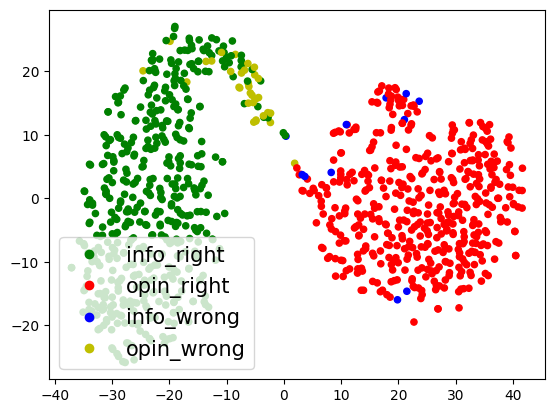

In [19]:
text_emb = np.array(ft_test_emb[12])    
dm_hd = eucl_dist_matr(text_emb)
X_embedded = mstsne(X_hds=text_emb, init='pca', n_components=2, dm_hds=dm_hd, seed_mstsne=seed)

colors = [0 for _ in X_embedded]
for pos, i in enumerate(X_embedded):
    if labels_test[pos] == 0 and preds_test_ft[pos] == 0:
        colors[pos] = 0
    elif labels_test[pos] == 1 and preds_test_ft[pos] == 1:
        colors[pos] = 1
    elif labels_test[pos] == 0 and preds_test_ft[pos] == 1:
        colors[pos] = 2
    elif labels_test[pos] == 1 and preds_test_ft[pos] == 0:
        colors[pos] = 3
colorMap = ListedColormap(['g','r','b', 'y'])
if dataset == 'infopinion':
    classes = ['info_right', 'opin_right', 'info_wrong', 'opin_wrong']
else: 
    classes = ['pos_right', 'neg_right', 'pos_wrong', 'neg_wrong']

scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=colors, cmap=colorMap, s=20)
plt.legend(handles=scatter.legend_elements()[0], labels=classes, loc='lower left', fontsize="15")
plt.show()

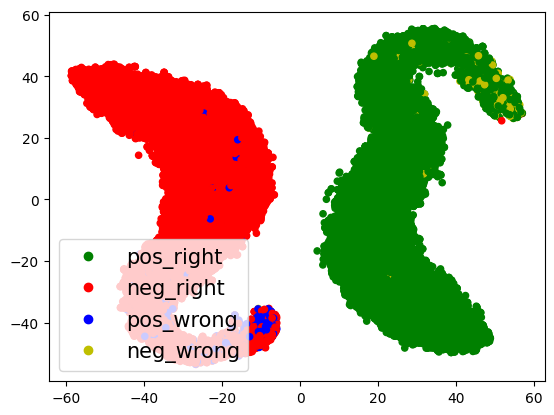

In [45]:
#X_emb_ft = X_embedded
#colors_ft = colors
#classes_ft = classes

scatter = plt.scatter(X_emb_ft[:,0], X_emb_ft[:,1], c=colors_ft, cmap=colorMap, s=20)
plt.legend(handles=scatter.legend_elements()[0], labels=classes_ft, loc='lower left', fontsize="15")
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

dim=768
pca_fro = PCA(dim)
plt.figure(figsize=(5,3))
reduced_fro = pca_fro.fit_transform(frozen_test_emb[12])
plt.plot([i for i in range(dim)], [sum(pca_fro.explained_variance_ratio_[:i])*100 for i in range(dim)], label='Frozen')

pca_ft = PCA(dim)
reduced_ft = pca_ft.fit_transform(ft_test_emb[12])

plt.plot([i for i in range(dim)], [sum(pca_ft.explained_variance_ratio_[:i])*100 for i in range(dim)], label='Fine-tuned')
plt.legend()
plt.title('Cumulative % of explained variance wrt the number of PCA dimension')
plt.show()

In [7]:
# Cross task fine-tuning: Need to first have both models trained and saved in memory

#0) Get the two models: ok
#1) Put the texts from dataset1 to dataset2 fine-tuned model: ok
#2) Extract the embeddings: ok
#3) Train a frozen model using the extracted embeddings: already done ? => No because head is not retrained
# => Need to train head on top of the finetuning (frozen way)

model_dataset1 = AutoModelForSequenceClassification.from_pretrained(f'Finetuned_model_{dataset}')
model_tokenizer =  AutoTokenizer.from_pretrained(f'Finetuned_model_{dataset}')
model_dataset1.eval()
model_dataset1.to(device)

model_dataset2 = AutoModelForSequenceClassification.from_pretrained(f'Finetuned_model_{dataset2}')
AutoTokenizer.from_pretrained(f'Finetuned_model_{dataset2}')
model_dataset2.eval()
model_dataset2.to(device)

from Code.model_explainer import extract_embeddings
ft_train_emb1, labels_train1, preds_train1 = extract_embeddings(train2, model_dataset1, layers = [12])
ft_val_emb1, labels_val1, preds_val1 = extract_embeddings(val2, model_dataset1, layers = [12])
ft_test_emb1, labels_test1, preds_test1 = extract_embeddings(test2, model_dataset1, layers = [12])

ft_train_emb2, labels_train2, preds_train2 = extract_embeddings(train, model_dataset2, layers = [12])
ft_val_emb2, labels_val2, preds_val2 = extract_embeddings(val, model_dataset2, layers = [12])
ft_test_emb2, labels_test2, preds_test2 = extract_embeddings(test, model_dataset2, layers = [12])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:57<00:00, 28.17it/s]


In [13]:
dataset = 'infopinion'
cross_model1 = train_frozen_model(rFrozen, ft_train_emb1[12], ft_val_emb1[12], labels_train1, labels_val1)
cross_preds1 = test_frozen_model(cross_model1, ft_test_emb1[12], labels_test1, get_preds = True)


======== Epoch 1 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]

/tmp/ipykernel_657426/4176119695.py:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  b_input_ids = torch.tensor(input_ids).to(device)



  Average training loss: 0.2742

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9210
  Validation Loss: 0.2256

======== Epoch 2 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.2105

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9150
  Validation Loss: 0.2642

======== Epoch 3 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1958

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9090
  Validation Loss: 0.2802

======== Epoch 4 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1860

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9080
  Validation Loss: 0.2781

======== Epoch 5 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1790

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9110
  Validation Loss: 0.2722

======== Epoch 6 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1737

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9130
  Validation Loss: 0.2672

======== Epoch 7 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1689

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9160
  Validation Loss: 0.2575

======== Epoch 8 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1646

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9160
  Validation Loss: 0.2498

======== Epoch 9 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1608

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9170
  Validation Loss: 0.2440

======== Epoch 10 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1571

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9180
  Validation Loss: 0.2383

======== Epoch 11 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1538

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9200
  Validation Loss: 0.2308

======== Epoch 12 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1503

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9220
  Validation Loss: 0.2208

======== Epoch 13 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1466

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9260
  Validation Loss: 0.2099

======== Epoch 14 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1429

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9300
  Validation Loss: 0.1982

======== Epoch 15 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1393

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9360
  Validation Loss: 0.1862

======== Epoch 16 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1356

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9430
  Validation Loss: 0.1765

======== Epoch 17 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1322

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9430
  Validation Loss: 0.1707

======== Epoch 18 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1293

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9440
  Validation Loss: 0.1705

======== Epoch 19 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1264

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9450
  Validation Loss: 0.1749

======== Epoch 20 / 20 ========
Training...


  0%|          | 0/8000 [00:00<?, ?it/s]


  Average training loss: 0.1229

Running Validation...


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9440
  Validation Loss: 0.1779


  0%|          | 0/1000 [00:00<?, ?it/s]

  Accuracy: 0.9550
  Test Loss: 0.1238


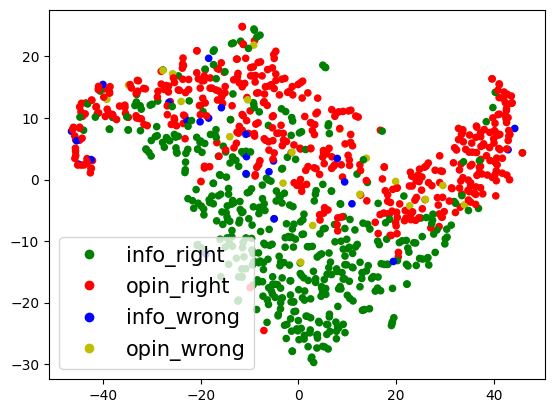

In [18]:
text_emb = np.array(ft_test_emb1[12])    
dm_hd = eucl_dist_matr(text_emb)
X_embedded = mstsne(X_hds=text_emb, init='pca', n_components=2, dm_hds=dm_hd, seed_mstsne=seed)

colors = [0 for _ in X_embedded]
for pos, i in enumerate(X_embedded):
    if labels_test1[pos] == 0 and cross_preds1[pos] == 0:
        colors[pos] = 0
    elif labels_test1[pos] == 1 and cross_preds1[pos] == 1:
        colors[pos] = 1
    elif labels_test1[pos] == 0 and cross_preds1[pos] == 1:
        colors[pos] = 2
    elif labels_test1[pos] == 1 and cross_preds1[pos] == 0:
        colors[pos] = 3
colorMap = ListedColormap(['g','r','b', 'y'])
if dataset == 'infopinion':
    classes = ['info_right', 'opin_right', 'info_wrong', 'opin_wrong']
else: 
    classes = ['pos_right', 'neg_right', 'pos_wrong', 'neg_wrong']

scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=colors, cmap=colorMap, s=20)
plt.legend(handles=scatter.legend_elements()[0], labels=classes, loc='lower left', fontsize="15")
plt.show()

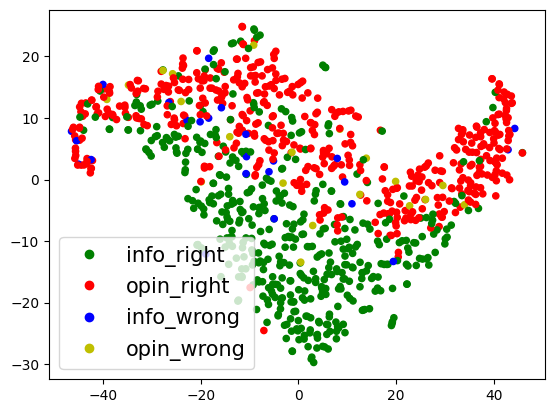

In [58]:
scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=colors, cmap=colorMap, s=20)
plt.legend(handles=scatter.legend_elements()[0], labels=classes, loc='lower left', fontsize="15")
plt.show()

In [19]:
dataset = 'allocine'
cross_model2 = train_frozen_model(rFrozen, ft_train_emb2[12], ft_val_emb2[12], labels_train2, labels_val2)
cross_preds2 = test_frozen_model(cross_model2, ft_test_emb2[12], labels_test2, get_preds = True)


======== Epoch 1 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.2199

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9354
  Validation Loss: 0.1730

======== Epoch 2 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1851

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9382
  Validation Loss: 0.1681

======== Epoch 3 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1804

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9385
  Validation Loss: 0.1660

======== Epoch 4 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1778

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9386
  Validation Loss: 0.1647

======== Epoch 5 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1759

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9396
  Validation Loss: 0.1638

======== Epoch 6 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1744

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9391
  Validation Loss: 0.1632

======== Epoch 7 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1732

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9392
  Validation Loss: 0.1627

======== Epoch 8 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1721

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9397
  Validation Loss: 0.1624

======== Epoch 9 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1712

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9404
  Validation Loss: 0.1622

======== Epoch 10 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1703

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9399
  Validation Loss: 0.1620

======== Epoch 11 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1695

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9398
  Validation Loss: 0.1618

======== Epoch 12 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1688

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9401
  Validation Loss: 0.1616

======== Epoch 13 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1680

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9400
  Validation Loss: 0.1612

======== Epoch 14 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1674

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9397
  Validation Loss: 0.1608

======== Epoch 15 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1667

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9398
  Validation Loss: 0.1604

======== Epoch 16 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1661

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9404
  Validation Loss: 0.1601

======== Epoch 17 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1655

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9403
  Validation Loss: 0.1601

======== Epoch 18 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1649

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9404
  Validation Loss: 0.1604

======== Epoch 19 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1644

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9404
  Validation Loss: 0.1605

======== Epoch 20 / 20 ========
Training...


  0%|          | 0/160000 [00:00<?, ?it/s]


  Average training loss: 0.1639

Running Validation...


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9401
  Validation Loss: 0.1591


  0%|          | 0/20000 [00:00<?, ?it/s]

  Accuracy: 0.9432
  Test Loss: 0.1538


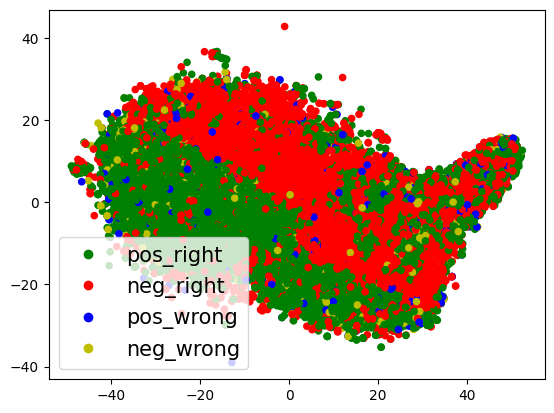

In [20]:
text_emb = np.array(ft_test_emb2[12])    
dm_hd = eucl_dist_matr(text_emb)
X_embedded = mstsne(X_hds=text_emb, init='pca', n_components=2, dm_hds=dm_hd, seed_mstsne=seed)

colors = [0 for _ in X_embedded]
for pos, i in enumerate(X_embedded):
    if labels_test2[pos] == 0 and cross_preds2[pos] == 0:
        colors[pos] = 0
    elif labels_test2[pos] == 1 and cross_preds2[pos] == 1:
        colors[pos] = 1
    elif labels_test2[pos] == 0 and cross_preds2[pos] == 1:
        colors[pos] = 2
    elif labels_test2[pos] == 1 and cross_preds2[pos] == 0:
        colors[pos] = 3
colorMap = ListedColormap(['g','r','b', 'y'])
if dataset == 'infopinion':
    classes = ['info_right', 'opin_right', 'info_wrong', 'opin_wrong']
else: 
    classes = ['pos_right', 'neg_right', 'pos_wrong', 'neg_wrong']

scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=colors, cmap=colorMap, s=20)
plt.legend(handles=scatter.legend_elements()[0], labels=classes, loc='lower left', fontsize="15")
plt.show()

In [ ]:
print("blbl")

In [15]:
from sklearn.decomposition import PCA 
pca = PCA(768)
Xs = pca.fit_transform(ft_test_emb2[12])
var = pca.explained_variance_ratio_
sumi = 0
for pos, i in enumerate(var):
    if sumi >= 0.95:
        print(sum(var[:pos]), pos)
        #print(var)
        break
    sumi += i



NameError: name 'ft_test_emb2' is not defined

In [19]:
import math
def z_score(p1, p2, n):
    P = (p1 + p2)/2
    return (p1-p2)/math.sqrt(P*(1-P)/n)
    
z_score(0.9560, 0.9620, 1000)

-0.9568635658861402